# Introduction

This notebook provides a baseline for each setting in [Subtask A of SemEval 2022 Task 2](https://sites.google.com/view/semeval2022task2-idiomaticity#h.qq7eefmehqf9). In addition this provides some helpful pre-processing scripts that you are free to use with your experiments. 

Please start by stepping through this notebook so you have a clear idea as to what is expected of the task and what you need to submit. 

These baselines are based on the results described in the paper “[AStitchInLanguageModels: Dataset and Methods for the Exploration of Idiomaticity in Pre-Trained Language Models](https://arxiv.org/abs/2109.04413)”. 

## Zero-shot setting: Methodology 

Note that in the zero-shot setting you are NOT allowed to train the model using the one-shot data. 

In the zero-shot setting, we choose to include the context (the sentences preceding and succeeding the one containing the idioms). We do not add the idiom as an additional feature (in the “second input sentence”). This is based on the results presented in the dataset paper. 

We use T5 transformer for this setting.

# Setup 

In [ ]:
!nvidia-smi

Mon Jan 30 11:11:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Download the Task data and evaluation scripts

In [ ]:
!git clone https://github.com/H-TayyarMadabushi/SemEval_2022_Task2-idiomaticity.git

Cloning into 'SemEval_2022_Task2-idiomaticity'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 123 (delta 48), reused 61 (delta 15), pack-reused 0
Receiving objects: 100% (123/123), 2.50 MiB | 2.23 MiB/s, done.
Resolving deltas: 100% (48/48), done.


Download the “AStitchInLanguageModels” code which we make use of. 

In [ ]:
!git clone https://github.com/H-TayyarMadabushi/AStitchInLanguageModels.git

Cloning into 'AStitchInLanguageModels'...
remote: Enumerating objects: 1030, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1030 (delta 11), reused 4 (delta 4), pack-reused 1013
Receiving objects: 100% (1030/1030), 79.59 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (394/394), done.


Download and install an editable version of huggingfaces transformers. 

In [ ]:
!git clone https://github.com/huggingface/transformers.git
%cd transformers/
!pip install --editable .
%cd /content/

Cloning into 'transformers'...
remote: Enumerating objects: 125165, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 125165 (delta 47), reused 59 (delta 40), pack-reused 125088
Receiving objects: 100% (125165/125165), 119.73 MiB | 9.78 MiB/s, done.
Resolving deltas: 100% (93942/93942), done.
/content/transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.9 MB/s eta 0:00:00
  Running setup.py develop for transformers
/content


Required for run_glue ... 

In [ ]:
## run_glue needs this. 
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Editable install requires runtime restart unless we do this. 

In [ ]:
import site
site.main()

# Imports and Helper functions

In [ ]:
import pandas as pd
import numpy as np 
import os 
from pathlib import Path
import csv 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string

In [ ]:
def load_csv( path, delimiter=',' ) : 
  header = None
  data   = list()
  with open( path, encoding='utf-8') as csvfile:
    reader = csv.reader( csvfile, delimiter=delimiter ) 
    for row in reader : 
      if header is None : 
        header = row
        continue
      data.append( row ) 
  return header, data

In [ ]:
def write_csv( data, location ) : 
  with open( location, 'w', encoding='utf-8') as csvfile:
    writer = csv.writer( csvfile ) 
    writer.writerows( data ) 
  print( "Wrote {}".format( location ) ) 
  return

In [ ]:

class Node():
  def __init__(self, sentence, label):
    self.sentence = sentence
    self.label = label

def create_idiom_dict_train(data_location, file_name) :
    idiom_dict = {}
    file_name = os.path.join( data_location, file_name ) 
    header, data = load_csv( file_name )
    for elem in data:
        label     = elem[ header.index( 'Label'  ) ]
        sentence  = elem[ header.index( 'Target' ) ]
        idiom = elem[ header.index( 'MWE' ) ]
        if idiom in idiom_dict:
          idiom_dict[idiom].append(Node(sentence, label))
        else:
          idiom_dict[idiom] = [Node(sentence, label)]
    return idiom_dict

In [ ]:
d1 = create_idiom_dict_train('SemEval_2022_Task2-idiomaticity/SubTaskA/Data/', 'train_zero_shot.csv')
d2 = create_idiom_dict_train('SemEval_2022_Task2-idiomaticity/SubTaskA/Data/', 'train_one_shot.csv')
for key, value in d2.items():
  if key in d1:
    d1[key].append(value)
  else:
    d1[key] = value

The following function creates a submission file from the predictions output by run_glue (the text classification script from huggingface transformers - see below). 

Note that we set it up so we can load up results for only one setting. 

It requires as input the submission format file, which is available with the data. You can call this after completing each setting to load up results for both settings (see below).


In [ ]:
def insert_to_submission_file( submission_format_file, input_file, prediction_format_file, setting ) :
    submission_header, submission_content = load_csv( submission_format_file )
    input_header     , input_data         = load_csv( input_file             )
    prediction_header, prediction_data    = load_csv( prediction_format_file, '\t' )

    assert len( input_data ) == len( prediction_data )

    ## submission_header ['ID', 'Language', 'Setting', 'Label']
    ## input_header      ['label', 'sentence1' ]
    ## prediction_header ['index', 'prediction']

    prediction_data = list( reversed( prediction_data ) )

    started_insert  = False
    for elem in submission_content : 
        if elem[ submission_header.index( 'Setting' ) ] != setting :
            if started_insert :
                if len( prediction_data ) == 0 :
                    break
                else : 
                    raise Exception( "Update should to contiguous ... something wrong." ) 
            continue
        started_insert = True
        elem[ submission_header.index( 'Label' ) ] = prediction_data.pop()[ prediction_header.index( 'prediction' ) ]

    return [ submission_header ] + submission_content

# Pre-process: Create train and dev and evaluation data in required format

In the zero-shot setting, we choose to include the context (the sentences preceding and succeeding the one containing the idioms). We do not add the idiom as an additional feature (in the “second input sentence”). 

In the one shot setting, we train the model on both the zero-shot and one-shot data. In this setting, we exclude the context (the sentences preceding and succeeding the one containing the idioms) and also add the idiom as an additional feature in the “second sentence”. 


## Functions for pre-processing

### _get_train_data

This function generates training data in the format required by the huggingface’s example script. It will include and exclude the MWE and the context based on parameters. 


In [ ]:

def _get_train_data( data_location, file_name, include_context, include_idiom ) :
    
    file_name = os.path.join( data_location, file_name ) 

    header, data = load_csv( file_name )

    out_header = [ 'label', 'sentence1' ]
    if include_idiom :
        out_header = [ 'label', 'sentence1', 'sentence2' ]
        
    # ['DataID', 'Language', 'MWE', 'Setting', 'Previous', 'Target', 'Next', 'Label']
    out_data = list()
    for elem in data :
        label     = elem[ header.index( 'Label'  ) ]
        sentence1 = elem[ header.index( 'Target' ) ]
        if include_context :
            sentence1 = ' '.join( [ elem[ header.index( 'Previous' ) ], elem[ header.index( 'Target' ) ], elem[ header.index( 'Next' ) ] ] )
        this_row = None
        if not include_idiom :
            this_row = [ label, sentence1 ] 
        else :
            sentence2 = elem[ header.index( 'MWE' ) ]
            this_row = [ label, sentence1, sentence2 ]
        out_data.append( this_row )
        assert len( out_header ) == len( this_row )
    return [ out_header ] + out_data

### _get_dev_eval_data

This function generates training dev and eval data in the format required by the huggingface’s example script. It will include and exclude the MWE and the context based on parameters. 

Additionally, if there is no gold label provides (as in the case of eval) it will generate a file that can be used to generate predictions.


In [ ]:
def _get_dev_eval_data( data_location, input_file_name, gold_file_name, include_context, include_idiom ) :

    input_headers, input_data = load_csv( os.path.join( data_location, input_file_name ) )
    gold_header  = gold_data = None
    if not gold_file_name is None : 
        gold_header  , gold_data  = load_csv( os.path.join( data_location, gold_file_name  ) )
        assert len( input_data ) == len( gold_data )

    # ['ID', 'Language', 'MWE', 'Previous', 'Target', 'Next']
    # ['ID', 'DataID', 'Language', 'Label']
    
    out_header = [ 'label', 'sentence1' ]
    if include_idiom :
        out_header = [ 'label', 'sentence1', 'sentence2' ]

    out_data = list()
    for index in range( len( input_data ) ) :
        label = 1
        if not gold_file_name is None : 
            this_input_id = input_data[ index ][ input_headers.index( 'ID' ) ]
            this_gold_id  = gold_data [ index ][ gold_header  .index( 'ID' ) ]
            assert this_input_id == this_gold_id
            
            label     = gold_data[ index ][ gold_header.index( 'Label'  ) ]
            
        elem      = input_data[ index ]
        sentence1 = elem[ input_headers.index( 'Target' ) ]
        if include_context :
            sentence1 = ' '.join( [ elem[ input_headers.index( 'Previous' ) ], elem[ input_headers.index( 'Target' ) ], elem[ input_headers.index( 'Next' ) ] ] )
        this_row = None
        if not include_idiom :
            this_row = [ label, sentence1 ] 
        else :
            sentence2 = elem[ input_headers.index( 'MWE' ) ]
            this_row = [ label, sentence1, sentence2 ]
        assert len( out_header ) == len( this_row ) 
        out_data.append( this_row )
        

    return [ out_header ] + out_data

def _get_dev_eval_data( data_location, input_file_name, gold_file_name, include_context, include_idiom ) :

    input_headers, input_data = load_csv( os.path.join( data_location, input_file_name ) )
    gold_header  = gold_data = None
    if not gold_file_name is None : 
        gold_header  , gold_data  = load_csv( os.path.join( data_location, gold_file_name  ) )
        assert len( input_data ) == len( gold_data )

    # ['ID', 'Language', 'MWE', 'Previous', 'Target', 'Next']
    # ['ID', 'DataID', 'Language', 'Label']
    
    out_header = [ 'label', 'sentence1' ]
    if include_idiom :
        out_header = [ 'label', 'sentence1', 'sentence2' ]

    out_data = list()
    for index in range( len( input_data ) ) :
        label = 1
        if not gold_file_name is None : 
            this_input_id = input_data[ index ][ input_headers.index( 'ID' ) ]
            this_gold_id  = gold_data [ index ][ gold_header  .index( 'ID' ) ]
            assert this_input_id == this_gold_id
            
            label     = gold_data[ index ][ gold_header.index( 'Label'  ) ]
            
        elem      = input_data[ index ]
        sentence1 = elem[ input_headers.index( 'Target' ) ]
        if include_context :
            sentence1 = ' '.join( [ elem[ input_headers.index( 'Previous' ) ], elem[ input_headers.index( 'Target' ) ], elem[ input_headers.index( 'Next' ) ] ] )
        this_row = None
        if not include_idiom :
            this_row = [ label, sentence1 ] 
        else :
            sentence2 = elem[ input_headers.index( 'MWE' ) ]
            this_row = [ label, sentence1, sentence2 ]
        assert len( out_header ) == len( this_row ) 
        out_data.append( this_row )
        

    return [ out_header ] + out_data

### create_data

This function generates the training, development and evaluation data. 


In [ ]:
"""
Based on the results presented in `AStitchInLanguageModels' we work with not including the idiom for the zero shot setting and including it in the one shot setting.
"""
def create_data( input_location, output_location ) :

    
    ## Zero shot data
    train_data = _get_train_data(
        data_location   = input_location,
        file_name       = 'train_zero_shot.csv',
        include_context = True,
        include_idiom   = False
    )
    write_csv( train_data, os.path.join( output_location, 'ZeroShot', 'train.csv' ) )
    
    dev_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'dev.csv',
        gold_file_name   = 'dev_gold.csv', 
        include_context  = True,
        include_idiom    = False
    )        
    write_csv( dev_data, os.path.join( output_location, 'ZeroShot', 'dev.csv' ) )
    
    eval_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'eval.csv',
        gold_file_name   = None , ## Don't have gold evaluation file -- submit to CodaLab
        include_context  = True,
        include_idiom    = False
    )
    write_csv( eval_data, os.path.join( output_location, 'ZeroShot', 'eval.csv' ) )


    ## OneShot Data (combine both for training)
    train_zero_data = _get_train_data(
        data_location   = input_location,
        file_name       = 'train_zero_shot.csv',
        include_context = False,
        include_idiom   = True
    )
    train_one_data = _get_train_data(
        data_location   = input_location,
        file_name       = 'train_one_shot.csv',
        include_context = False,
        include_idiom   = True
    )

    assert train_zero_data[0] == train_one_data[0] ## Headers
    train_data = train_one_data + train_zero_data[1:]
    write_csv( train_data, os.path.join( output_location, 'OneShot', 'train.csv' ) )
    
    dev_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'dev.csv',
        gold_file_name   = 'dev_gold.csv', 
        include_context  = False,
        include_idiom    = True
    )        
    write_csv( dev_data, os.path.join( output_location, 'OneShot', 'dev.csv' ) )
    
    eval_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'eval.csv',
        gold_file_name   = None,
        include_context  = False,
        include_idiom    = True
    )
    write_csv( eval_data, os.path.join( output_location, 'OneShot', 'eval.csv' ) )

    return

## Setup and Create data

In [ ]:
!ls

AStitchInLanguageModels  sample_data			  transformers
Data			 SemEval_2022_Task2-idiomaticity


##Explotary data analysis

train_zero_shot.csv

In [ ]:
directory   = 'SemEval_2022_Task2-idiomaticity/SubTaskA/Data/'
zero_shot_tr = os.path.join(directory, 'train_zero_shot.csv')
one_shot_tr = os.path.join(directory, 'train_one_shot.csv')
dev = os.path.join(directory, 'dev.csv')
dev_gold = os.path.join(directory, 'dev_gold.csv')

df_z_s = pd.read_csv(zero_shot_tr)
df_o_s= pd.read_csv(one_shot_tr)
df_dev = pd.read_csv(dev)
df_dev_gold= pd.read_csv(dev_gold)
df_dev= df_dev.merge(df_dev_gold, validate='one_to_one')
dfs = {'Zero Shot Data': df_z_s}

In [ ]:
display(df_z_s)

,DataID,Language,MWE,Setting,Previous,Target,Next,Label
0,train_zero_shot.EN.168.1,EN,double dutch,zero_shot,This inspired others to jump ropes as a leisur...,There are several theories behind the origin o...,The most popular theory states that “Double Du...,0
1,train_zero_shot.EN.168.2,EN,double dutch,zero_shot,In the age of chivalry a man paid for the woma...,"Double Dutch also derives from the same era, D...",There are many phrases that include the word: ...,0
2,train_zero_shot.EN.168.3,EN,double dutch,zero_shot,"To her eternal credit, she kept both India and...",Since 1977 we have had a plethora of Foreign M...,We need to exclude from that list the late Mr ...,0
3,train_zero_shot.EN.168.4,EN,double dutch,zero_shot,While pharmaceutical companies were researchin...,Turns out that these people were speaking doub...,So why aren’t Big Macs sold all over the world...,0
4,train_zero_shot.EN.168.5,EN,double dutch,zero_shot,Coronavirus in Europe * Brexit * Brussels ...,Is Flemish premier talking double Dutch?,Three months before the Belgians take over the...,0
...,...,...,...,...,...,...,...,...
4486,train_zero_shot.PT.351.8,PT,gato-pingado,zero_shot,Era o ano de 1968.,"A estação de passageiros tranquila, com um ou...","Com os primeiros raios solares, o potente DC 8...",0
4487,train_zero_shot.PT.351.9,PT,gato-pingado,zero_shot,De acordo com informações vazadas de dentro da...,"Segundo a fonte, o programa vai seguir um form...","Leonardo fica inchado, perde a voz e vício mor...",0
4488,train_zero_shot.PT.351.10,PT,gato-pingado,zero_shot,O radialista Roberto Toledo apresentou o show ...,"""Eu fiquei sentado no chão e realmente só tinh...",Entre os poucos espectadores estava o advogado...,0
4489,train_zero_shot.PT.351.11,PT,gato-pingado,zero_shot,O carnaval em Goiânia também tem espaço para o...,"É o caso do bloco “Gato Pingado”, que reuniu c...","Segundo os organizadores, quando criaram o blo...",1


In [ ]:
display(df_dev)

,ID,Language,MWE,Previous,Target,Next,DataID,Label
0,3652,EN,high life,"Does the plumbing predictably rebel, creating ...",Are these interruptions of the good life a nec...,"Not at all , says James von Klemperer, preside...",dev.EN.147.1,1
1,11103,EN,high life,Let’s be honest – we would be chuffed if our b...,But for Australian fashion designer Abby Kheir...,"Speaking to the Daily Mail , the owner of Abys...",dev.EN.147.2,1
2,84346,EN,high life,I already have the winning ticket.,"With that, I will be enjoying the pleasures of...","Charles Selle is a former News-Sun reporter, p...",dev.EN.147.3,1
3,56279,EN,high life,"There were signs everywhere of cosy, comfortab...","Fendi offered swaddling, belted coats resembli...",Shawl collars and enveloping dressing-gown sty...,dev.EN.147.4,1
4,17886,EN,high life,Yet one thing is clear.,"Rick Ross and Diddy exemplify the high life, t...",And who knows -- maybe we'll see Puff on his a...,dev.EN.147.5,1
...,...,...,...,...,...,...,...,...
734,95336,PT,papel higiênico,"O presidente da Suzano Papel e Celulose, Walte...",A Suzano Papel e Celulose é uma das 10 maiores...,Vale destacar que a Suzano já recebeu menos en...,dev.PT.394.4,1
735,20353,PT,papel higiênico,"Atualmente, poderiam surgir problemas com carg...","O presidente da Suzano Papel e Celulose, Walte...",A Suzano Papel e Celulose é uma das 10 maiores...,dev.PT.394.5,1
736,54479,PT,papel higiênico,Policiais penais do Complexo Penitenciário Dr ...,O material entorpecente estava escondido em ro...,O flagrante ocorreu na manhã desta sexta-feira...,dev.PT.394.6,1
737,85941,PT,papel higiênico,O acidente ocorreu depois de fortes rajadas de...,"No caso do papel higiênico, a escassez de cont...","Schalka, da Suzano, teme que os problemas logí...",dev.PT.394.7,1


In [ ]:
display(df_dev_gold)

,ID,DataID,Language,Label
0,3652,dev.EN.147.1,EN,1
1,11103,dev.EN.147.2,EN,1
2,84346,dev.EN.147.3,EN,1
3,56279,dev.EN.147.4,EN,1
4,17886,dev.EN.147.5,EN,1
...,...,...,...,...
734,95336,dev.PT.394.4,PT,1
735,20353,dev.PT.394.5,PT,1
736,54479,dev.PT.394.6,PT,1
737,85941,dev.PT.394.7,PT,1


In [ ]:
for key, df in dfs.items():
    print("\n"+"#"*((40 - len(key))//2)+" {} ".format(key)+"#"*((40 - len(key))//2))
    print("\nTotal Samples: {}".format(len(df)))
    for col in ["Language", "Label", "MWE"]:
        value_counts = df[col].value_counts()
        unique_values = len(value_counts)
        if len(value_counts) > 5:
            print("\n{}".format(value_counts.iloc[:3].append(value_counts[-3:])))
        else:
            print("\n{}".format(value_counts))
        print("Number of {}s: {}".format(col, unique_values))


############# Zero Shot Data #############

Total Samples: 4491

EN    3327
PT    1164
Name: Language, dtype: int64
Number of Languages: 2

0    2535
1    1956
Name: Label, dtype: int64
Number of Labels: 2

information age     34
brass ring          32
peace talk          31
ônibus executivo     9
double dutch         9
algodão-doce         6
Name: MWE, dtype: int64
Number of MWEs: 236


In [ ]:
zero_shot_unique_eng_mwes = len(set(df_z_s[df_z_s["Language"] == 'EN']["MWE"]))
zero_shot_unique_pt_mwes = len(set(df_z_s[df_z_s["Language"] == 'PT']["MWE"]))
print("Number of English MWEs in zero shot data: {}".format(zero_shot_unique_eng_mwes))
print("Number of Portuguese MWEs in zero shot data: {}".format(zero_shot_unique_pt_mwes))

Number of English MWEs in zero shot data: 163
Number of Portuguese MWEs in zero shot data: 73


In [ ]:
common_zero_one = set(df_z_s['MWE']) & set(df_o_s['MWE'])
common_zero_dev = set(df_z_s['MWE']) & set(df_dev['MWE'])
common_one_dev = set(df_o_s['MWE']) & set(df_dev['MWE'])
print("Number of common MWEs in zero and one shot data: {}".format(len(common_zero_one)))
print("Number of common MWEs in zero shot and dev data: {}".format(len(common_zero_dev)))
print("Number of common MWEs in one shot and dev data: {}".format(len(common_one_dev)))

Number of common MWEs in zero and one shot data: 0
Number of common MWEs in zero shot and dev data: 0
Number of common MWEs in one shot and dev data: 50


In [ ]:
outpath = 'Data'
    
Path( os.path.join( outpath, 'ZeroShot' ) ).mkdir(parents=True, exist_ok=True)
Path( os.path.join( outpath, 'OneShot' ) ).mkdir(parents=True, exist_ok=True)

create_data( 'SemEval_2022_Task2-idiomaticity/SubTaskA/Data/', outpath )

Wrote Data/ZeroShot/train.csv
Wrote Data/ZeroShot/dev.csv
Wrote Data/ZeroShot/eval.csv
Wrote Data/OneShot/train.csv
Wrote Data/OneShot/dev.csv
Wrote Data/OneShot/eval.csv


Load train.csv file

In [ ]:
directory   = '/content/Data/ZeroShot'
zs_tr = os.path.join(directory, 'train.csv')

df_zs = pd.read_csv(zs_tr)

In [ ]:
display(df_zs)

,label,sentence1
0,0,This inspired others to jump ropes as a leisur...
1,0,In the age of chivalry a man paid for the woma...
2,0,"To her eternal credit, she kept both India and..."
3,0,While pharmaceutical companies were researchin...
4,0,Coronavirus in Europe * Brexit * Brussels ...
...,...,...
4486,0,Era o ano de 1968. A estação de passageiros t...
4487,0,De acordo com informações vazadas de dentro da...
4488,0,O radialista Roberto Toledo apresentou o show ...
4489,1,O carnaval em Goiânia também tem espaço para o...


#Dataset preprocessing

In [ ]:
#Removing columns which are not required
data = df_z_s.drop(["DataID", "Language", "Setting", "Previous", "Next"], axis = 1)

In [ ]:
data.head()

,MWE,Target,Label
0,double dutch,There are several theories behind the origin o...,0
1,double dutch,"Double Dutch also derives from the same era, D...",0
2,double dutch,Since 1977 we have had a plethora of Foreign M...,0
3,double dutch,Turns out that these people were speaking doub...,0
4,double dutch,Is Flemish premier talking double Dutch?,0


In [ ]:
data.isnull().sum()

MWE       0
Target    0
Label     0
dtype: int64

Randomly shuffling the dataframe

In [ ]:
data = data.sample(frac = 1)

In [ ]:
data.head()

,MWE,Target,Label
2497,academy award,"Cloris Leachman, who won eight Emmy Awards and...",1
3994,café colonial,"Alguns ficaram dentro do imóvel, outros do lad...",0
0,double dutch,There are several theories behind the origin o...,0
2774,couch potato,"But for one lucky couch potato, it will.",0
1115,swimming pool,To ascertain that such a situation doesn’t ari...,1


##Creating a function to convert the text in lowercase, remove the extra space, special chr., ulr and links.

For target sentence

In [ ]:
def wordopt(Target):
    text = Target.lower()
    text = re.sub('\[.*?\]', '', Target)
    text = re.sub("\\W"," ",Target)
    text = re.sub('https?://\S+|www\.\S+', '', Target)
    text = re.sub('<.*?>+', '', Target)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', Target)
    text = re.sub('\n', '', Target)
    text = re.sub('\w*\d\w*', '', Target)    
    return text

In [ ]:
data["Target"] = data["Target"].apply(wordopt)

##Merge target and MWE

In [ ]:
# Merge columns using the "merge" function
data["text"] = data["MWE"].map(str) + data["Target"].map(str)

# Print the updated DataFrame
print(data)

                    MWE                                             Target  \
2497      academy award  Cloris Leachman, who won eight Emmy Awards and...   
3994      café colonial  Alguns ficaram dentro do imóvel, outros do lad...   
0          double dutch  There are several theories behind the origin o...   
2774       couch potato           But for one lucky couch potato, it will.   
1115      swimming pool  To ascertain that such a situation doesn’t ari...   
...                 ...                                                ...   
1982   social insurance  Simply put, can we imagine the U.S. Congress s...   
1362         brass ring  Hosting on Fox News is the brass ring for talent.   
404         melting pot  The historic neighborhood was once a bustling ...   
2020         box office  He said the film will also be remembered as tu...   
692   grandfather clock  Stewart's flair for drama gives some of the al...   

      Label                                               text 

In [ ]:
data.head()

,MWE,Target,Label,text
2497,academy award,"Cloris Leachman, who won eight Emmy Awards and...",1,"academy awardCloris Leachman, who won eight Em..."
3994,café colonial,"Alguns ficaram dentro do imóvel, outros do lad...",0,"café colonialAlguns ficaram dentro do imóvel, ..."
0,double dutch,There are several theories behind the origin o...,0,double dutchThere are several theories behind ...
2774,couch potato,"But for one lucky couch potato, it will.",0,"couch potatoBut for one lucky couch potato, it..."
1115,swimming pool,To ascertain that such a situation doesn’t ari...,1,swimming poolTo ascertain that such a situatio...


In [ ]:
columns = ['MWE', 'Target']
data.drop(columns, inplace=True, axis=1)

In [ ]:
df = data

In [ ]:
df.head()

,Label,text
2497,1,"academy awardCloris Leachman, who won eight Em..."
3994,0,"café colonialAlguns ficaram dentro do imóvel, ..."
0,0,double dutchThere are several theories behind ...
2774,0,"couch potatoBut for one lucky couch potato, it..."
1115,1,swimming poolTo ascertain that such a situatio...


In [ ]:
df['Label'].value_counts()

0    2535
1    1956
Name: Label, dtype: int64

We can see that all the datasets have almost equal distribution of idiom (1) and literal (0) categories

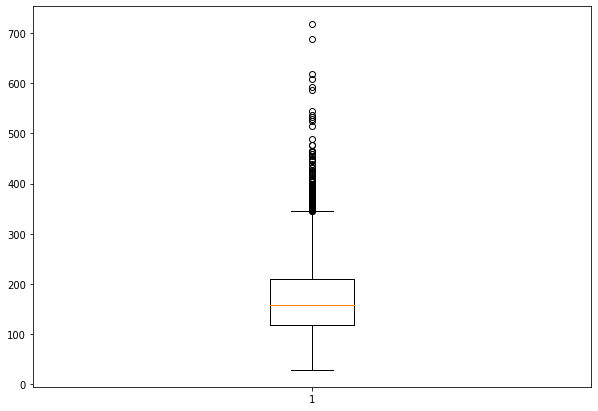

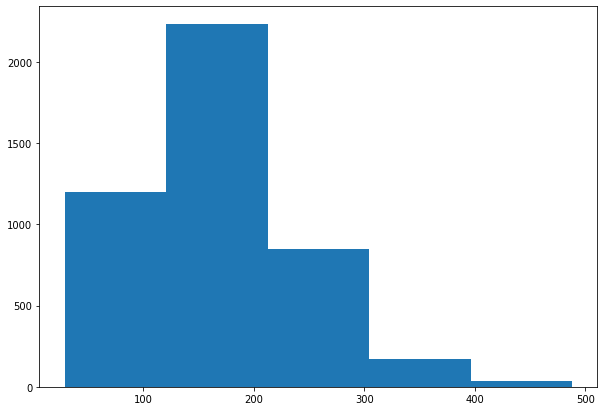

In [ ]:
#Analyzing length of sentences in training data to decide on MAX_LENGTH variable, which is required for BERT and RoBERTa

sent_len = []
for sent in df['text']:
  sent_len.append(len(sent))

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sent_len)
plt.show()

sent_len = [i for i in sent_len if i<=500] #Excluding the outliers
fig2 = plt.figure(figsize =(10, 7))
plt.hist(sent_len, 5)
plt.show()

## Split dataset

In [ ]:
import gensim 
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
y = df["Label"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [ ]:
X[:1]

[['academy',
  'awardcloris',
  'leachman',
  'eight',
  'emmy',
  'awards',
  'academy',
  'award',
  'career',
  'spanned',
  'nine',
  'decades',
  'passed',
  'away',
  'age']]

In [ ]:
y[:5]

array([1, 0, 0, 0, 1])

In [ ]:
X = df["text"]
y = df["Label"]

#T5 Model Implementation

##Installing necessary libraries for T5 model

In [ ]:
!pip install transformers
!pip install git+https://github.com/huggingface/transformers 

import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader 

!pip install sentencepiece 
!pip install datsets transformers[sentencepiece]import sentencepiece as spm 
!pip install pytorch_lightning 
import pytorch_lightning as pl
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

from transformers.utils import check_min_version
from transformers.trainer_utils import get_last_checkpoint, is_main_process 

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-tanu9tjv
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-tanu9tjv
  Resolved https://github.com/huggingface/transformers to commit c749bd405e94f7eb702f82d4706fc069de928d8e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.27.0.dev0-py3-none-any.whl size=6335189 sha256=afe8871ad868935573f33a0464985f263fef8bae37c270648dcadf212d3f4203
  Stored in directory: /tmp/pip-ephem-wheel-cache-6kxcwcv9/wheels/42/68/45/c63edff61c292f2dfd4df4ef6

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.7 MB/s eta 0:00:00
ERROR: Invalid requirement: 'transformers[sentencepiece]import'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 40.8 MB/s eta 0:00:00


device(type='cuda', index=0)

In [ ]:
# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
check_min_version("4.6.0.dev0")

task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

logger = logging.getLogger(__name__)

##Model Implementation

In [ ]:
from transformers import T5Tokenizer, T5Model
from transformers import AutoModel, AutoTokenizer 
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
# Loading T5 base model 

model_name = "t5-small"
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tell pytorch to run this model on the GPU.
t5_model.cuda()

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

Demonstrating how t5 tokenizers work on a sample sentence

In [ ]:
# Print the original sentence.
print(' Original: ', df["text"][0])

# Split the sentence into tokens - T5
print('Tokenized T5: ', t5_tokenizer.tokenize(df["text"][0]))

 Original:  double dutchThere are several theories behind the origin of the term “Double Dutch.”
Tokenized T5:  ['▁double', '▁du', 't', 'ch', 'There', '▁are', '▁several', '▁theories', '▁behind', '▁the', '▁origin', '▁of', '▁the', '▁term', '▁“', 'Do', 'u', 'ble', '▁Dutch', '.”']


In [ ]:
#assigning text and class to separate variables
text = df["text"].values
labels = df["Label"].values

In [ ]:
# Below function performs tokenization process as required by t5 model, for a given dataset
def t5_tokenization(dataset):
  sentences = dataset["text"].values
  labels = dataset["Label"].values
  max_length = 512

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  t5_input_ids = []
  t5_attention_masks = []

  sentence_ids = []
  counter = 0

  # For every sentence...
  for sent in sentences:
      #encode_plus function will encode the sentences as required by themodel, including tokenization process and mapping token ids
      t5_encoded_dict = t5_tokenizer.encode_plus (
                          str(sent),        #sentence              
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens 
                          max_length = 512,     #Since we have seen from our analysis that majority of sentences have length less than 300.    
                          pad_to_max_length = True,    # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,  # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
    
      # Add the encoded sentence to the list.    
      t5_input_ids.append(t5_encoded_dict['input_ids'])
      
      # Add attention mask to the list 
      t5_attention_masks.append(t5_encoded_dict['attention_mask'])
      
      
      # collecting sentence_ids
      sentence_ids.append(counter)
      counter  = counter + 1
      
      
  # Convert the lists into tensors.
  t5_input_ids = torch.cat(t5_input_ids, dim=0)
  t5_attention_masks = torch.cat(t5_attention_masks, dim=0)


  labels = torch.tensor(labels)
  sentence_ids = torch.tensor(sentence_ids)

  return {"T5":[t5_input_ids, t5_attention_masks, labels]}

In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

#tokenizing train set
token_dict_train = t5_tokenization(df)

t5_input_ids,t5_attention_masks,labels = token_dict_train["T5"]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2343: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Combine the training inputs into a TensorDataset.
t5_train_dataset = TensorDataset( t5_input_ids,t5_attention_masks, labels)

In [ ]:
# Combine the training inputs into a TensorDataset.
t5_train_dataset = TensorDataset( t5_input_ids, t5_attention_masks, labels)

In [ ]:
#Create a 90-10 train-validation split
train_size = int(0.9 * len(t5_train_dataset))
val_size = len(t5_train_dataset) - train_size
train_dataset, val_dataset = random_split(t5_train_dataset, [train_size, val_size])

In [ ]:
# Create data loaders for the train and validation sets
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Create an instance of the T5 model and the trainer
t5_model = T5ForConditionalGeneration.from_pretrained(model_name)
# Tell pytorch to run this model on the GPU.
t5_model.cuda()

# Create an instance of the trainer
optimizer = AdamW(t5_model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=-1)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from torch import nn
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score

In [ ]:
#training with more than one epoch
# Number of training epochs (passes through the dataset)
num_epochs = 2

# Track the training loss and accuracy
train_loss_set = []
train_acc_set = []

# Start training
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for step, batch in enumerate(train_dataloader):
        # Unpack the batch
        b_input_ids, b_attention_masks, b_labels = batch

        # Move the inputs and labels to the GPU
        b_input_ids = b_input_ids.to(device)
        b_attention_masks = b_attention_masks.to(device)
        b_labels = b_labels.to(device)

        # Zero-out the gradients from previous iteration
        t5_model.zero_grad()

        # Get the logits from the model
        # Get the logits from the model
        logits = t5_model(input_ids=b_input_ids, attention_mask=b_attention_masks,decoder_input_ids=b_input_ids)

        # Compute the loss
        loss_func = nn.CrossEntropyLoss()
        loss = loss_func(logits.view(-1, logits.shape[-1]), b_labels.view(-1))

        # Perform backpropagation
        loss.backward()

        # Update the parameters
        optimizer.step()
        scheduler.step()

        # Track the training loss and f1_score
        train_loss_set.append(loss.item())
        train_acc_set.append(f1_score(logits, b_labels))

Epoch 1/2


OutOfMemoryError: ignored

In [ ]:
#training with one epoch
# Set the model to train mode
t5_model.train()

# Loop over the data
for input_ids, attention_masks, labels in train_dataloader:
    # Move the input and labels to the GPU
    input_ids = input_ids.to('cuda')
    attention_masks = attention_masks.to('cuda')
    labels = labels.to('cuda')

    # Zero the gradients
    optimizer.zero_grad()

    # Perform a forward pass
    outputs = t5_model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
    loss = outputs[0]

    # Perform backpropagation and optimization
    loss.backward()
    optimizer.step()
    scheduler.step()

# Zero Shot Setting

## Train Zero shot

In [ ]:
!python /content/AStitchInLanguageModels/Dataset/Task2/Utils/run_glue_f1_macro.py \
        --model_name_or_path 't5-small' \
        --do_train \
        --do_eval \
        --max_seq_length 128 \
        --per_device_train_batch_size 32 \
        --learning_rate 2e-5 \
        --num_train_epochs 9 \
        --evaluation_strategy "epoch" \
        --output_dir models/ZeroShot/0/ \
        --seed 0 \
        --train_file      Data/ZeroShot/train.csv \
        --validation_file Data/ZeroShot/dev.csv \
        --evaluation_strategy "epoch" \
        --save_strategy "epoch"  \
        --load_best_model_at_end \
        --metric_for_best_model "f1" \
        --save_total_limit 1

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## Create save path
!mkdir -p /content/gdrive/MyDrive/ColabData/SemEval2022Task2/TaskA/ZeroShot/0/
## Copy saved model.
!cp -r /content/models/ZeroShot/0/* /content/gdrive/MyDrive/ColabData/SemEval2022Task2/TaskA/ZeroShot/0/

In [ ]:
## Bring back saved model here. 
#!mkdir -p /content/models/ZeroShot/0/
# !cp -r /content/gdrive/MyDrive/ColabData/SemEval2022Task2/TaskA/ZeroShot/0/* /content/models/ZeroShot/0/

## Evaluation On Dev Data

In [ ]:
!python /content/AStitchInLanguageModels/Dataset/Task2/Utils/run_glue_f1_macro.py \
        --model_name_or_path '/content/models/ZeroShot/0' \
        --do_predict \
        --max_seq_length 128 \
        --per_device_train_batch_size 32 \
        --learning_rate 2e-5 \
        --num_train_epochs 9 \
        --evaluation_strategy "epoch" \
        --output_dir models/ZeroShot/0/eval-dev/ \
        --seed 0 \
        --train_file      Data/ZeroShot/train.csv \
        --validation_file Data/ZeroShot/dev.csv \
      --test_file Data/ZeroShot/dev.csv \
        --evaluation_strategy "epoch" \
        --save_strategy "epoch"  \
        --load_best_model_at_end \
        --metric_for_best_model "f1" \
        --save_total_limit 1

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=True,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for

### Use predictions to create the submission file (for dev data)

In [ ]:
params = {
    'submission_format_file' : '/content/SemEval_2022_Task2-idiomaticity/SubTaskA/Data/dev_submission_format.csv' ,
    'input_file'             : '/content/SemEval_2022_Task2-idiomaticity/SubTaskA/Data/dev.csv'                   ,
    'prediction_format_file' : '/content/models/ZeroShot/0/eval-dev/test_results_None.txt'                        ,
    }
params[ 'setting' ] = 'zero_shot'

In [ ]:
 updated_data = insert_to_submission_file( **params )

In [ ]:
!mkdir -p outputs

In [ ]:
write_csv( updated_data, 'outputs/zero_shot_dev_formated.csv' ) 

Wrote outputs/zero_shot_dev_formated.csv


### For the development data, we can run evaluation script.

In [ ]:
import sys
sys.path.append( '/content/SemEval_2022_Task2-idiomaticity/SubTaskA/' ) 
from SubTask1Evaluator import evaluate_submission


submission_file = 'outputs/zero_shot_dev_formated.csv'
gold_file       = '/content/SemEval_2022_Task2-idiomaticity/SubTaskA/Data/dev_gold.csv'

results = evaluate_submission( submission_file, gold_file )
%reload_ext google.colab.data_table
import pandas as pd
df = pd.DataFrame(data=results[1:], columns=results[0])
df

,Settings,Languages,F1 Score (Macro)
0,zero_shot,EN,0.661751
1,zero_shot,PT,0.638556
2,zero_shot,"EN,PT",0.673019
3,one_shot,EN,"(None, None, None)"
4,one_shot,PT,"(None, None, None)"
5,one_shot,"EN,PT","(None, None, None)"


## Generate Eval Data output

In [ ]:
!python /content/AStitchInLanguageModels/Dataset/Task2/Utils/run_glue_f1_macro.py \
    	--model_name_or_path '/content/models/ZeroShot/0' \
    	--do_predict \
    	--max_seq_length 128 \
    	--per_device_train_batch_size 32 \
    	--learning_rate 2e-5 \
    	--num_train_epochs 9 \
    	--evaluation_strategy "epoch" \
    	--output_dir models/ZeroShot/0/eval-eval/ \
    	--seed 0 \
    	--train_file      Data/ZeroShot/train.csv \
    	--validation_file Data/ZeroShot/dev.csv \
      --test_file Data/ZeroShot/eval.csv \
	    --evaluation_strategy "epoch" \
	    --save_strategy "epoch"  \
	    --load_best_model_at_end \
	    --metric_for_best_model "f1" \
	    --save_total_limit 1

09/03/2021 19:13:53 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
09/03/2021 19:13:53 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=True,
do_train=False,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.EPOCH,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
greater_is_better=True,
group_by_length=False,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=2e-05,
length_column_name=length,
load_best_model_at_end=True,
local_rank=-1,
log_level=-1,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=model

### Use predictions to create the submission file (for eval data)

In [ ]:
params = {
    'submission_format_file' : '/content/SemEval_2022_Task2-idiomaticity/SubTaskA/Data/eval_submission_format.csv' ,
    'input_file'             : '/content/SemEval_2022_Task2-idiomaticity/SubTaskA/Data/eval.csv'                   ,
    'prediction_format_file' : '/content/models/ZeroShot/0/eval-eval/test_results_None.txt'                        ,
    }
params[ 'setting' ] = 'zero_shot'

In [ ]:
 updated_data = insert_to_submission_file( **params )

In [ ]:
write_csv( updated_data, 'outputs/zero_shot_eval_formated.csv' )

Wrote outputs/zero_shot_eval_formated.csv


**NOTE**: You can submit this file, but it only has results for the zero-shot setting.

# Download Submission File

In [ ]:
from google.colab import files
files.download('/content/outputs/task2_subtaska.csv') 
## Remeber to put this in a folder called "submission".

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Discussion

In [ ]:
df

,Settings,Languages,F1 Score (Macro)
0,zero_shot,EN,0.661751
1,zero_shot,PT,0.638556
2,zero_shot,"EN,PT",0.673019
3,one_shot,EN,0.870489
4,one_shot,PT,0.866575
5,one_shot,"EN,PT",0.873821


Notice the significant jump in F1 scores with the introduction of just one positive and one negative example. 

Note that your position on the leaderboard will be based on rows with index 2 and 5 (combined results for both languages). The rest of the results for information and ablation studies. 



